In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
##Inputs:
#path
filename = r"C:\Users\roger\PycharmProjects\algotrading\self_data\btcusd.csv"
#Expected Columns:
#time  open  close  high  low  volume

##Val Inputs:
time_stops = [100]
take_profits = [.02]
short_mas = [50]
long_mas = [500]
##Optional: Test grid using arrays below. Params are hard-coded for this run.
#time_stops = np.arange(100, 1000, 200)
#take_profits = np.arange(.01, .1, .02)
#short_mas = np.arange(20, 60, 8)
#long_mas = np.arange(100, 1000, 200)

In [3]:
price_dict = {}
id_counter = 1
trade_log = []
date_log = []
price_outcomes = []
trade_counter = 0

In [4]:
with open(filename, 'r+', encoding= 'utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        price_dict[id_counter] = row
        id_counter += 1
original_dict = price_dict

In [5]:
def full_func(time_stop, take_profit, short_ma, long_ma):
    price_dict = original_dict
    open_price_list = [float(x[1]) for x in list(price_dict.values())[1:]]
    first_pass = False
    velocity_ratio_list = []
    for key in list(price_dict.keys())[long_ma + 3:]:
        array = open_price_list[key - 2 - long_ma:key - 2]
        ma = sum(array) / len(array)
        price_dict[key].append(ma)
        if first_pass:
            velocity = ma / price_dict[key - 1][6]
            price_dict[key].append(velocity)
            velocity_ratio_list.append(velocity)
        first_pass = True
    for key in list(price_dict.keys())[short_ma + 3:]:
        array = open_price_list[key - 2 - short_ma:key - 2]
        ma = sum(array) / len(array)
        price_dict[key].append(ma)
    try:
        del price_dict[1]
    except:
        pass
    
    #ma_velocity grid is hard coded to a single val to prevent lengthy run time. Uncomment second line to iter through grid.
    ma_velocity_grid = [1.0001301155064284]
    #ma_velocity_grid = np.arange(1.00, max(velocity_ratio_list), (max(velocity_ratio_list) - 1.00) / 10)
    for ma_velocity in ma_velocity_grid:
        trade_outcomes = []
        counter = 0
        for key in list(price_dict.keys())[long_ma + 4:]:
            velocity_pass = False
            if price_dict[key][7] > ma_velocity:
                velocity_pass = True
            if not velocity_pass:
                continue
            if float(price_dict[key-1][1]) > price_dict[key-1][8] and float(price_dict[key][1]) < price_dict[key][8]:
                buy_price = float(price_dict[key][1])
                for keykey in list(price_dict.keys())[key+1:]:
                    potential_outcome = (float(price_dict[keykey][1]) - buy_price) / buy_price
                    tick_delta = keykey - key
                    if potential_outcome >= take_profit or tick_delta >= time_stop:
                        sell_price = float(price_dict[keykey][1])
                        price_outcomes.append(sell_price)
                        outcome = (sell_price - buy_price) / buy_price
                        trade_outcomes.append(outcome)
                        break
        return trade_outcomes, price_outcomes
##Uncomment below when using grid to view performance summary per each iter.
#         if len(trade_outcomes) > 0:
#             average = (sum(trade_outcomes) / len(trade_outcomes))
#             performance = [average, len(trade_outcomes), time_stop, take_profit, short_ma, long_ma, ma_velocity]
#             print(performance)
#             try:
#                 average_positive = sum([x for x in trade_outcomes if x > 0]) / len([x for x in trade_outcomes if x > 0])
#                 average_negative = sum([x for x in trade_outcomes if x < 0]) / len([x for x in trade_outcomes if x < 0])
#                 print('Average Gain: ' + str(average_positive))
#                 print('Average Loss: ' + str(average_negative))
#             except:
#                 pass

In [6]:
for time_stop in time_stops:
    for take_profit in take_profits:
        for short_ma in short_mas:
            for long_ma in long_mas:
                trade_journal, price_journal = full_func(time_stop, take_profit, short_ma, long_ma)

In [7]:
best = max(trade_journal)
worst = min(trade_journal)
mean = np.mean(trade_journal)
print('Highest HPR:', best)
print('Worst Drawdown:', worst)
print('Mean:', mean)

Highest HPR: 0.2684185114181414
Worst Drawdown: -0.3122393083554833
Mean: 0.003969516143882302


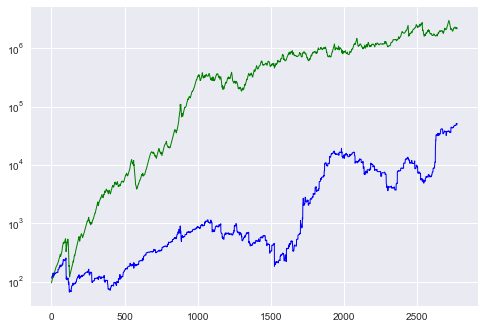

In [8]:
starting_equity = float(price_dict[2][1])
equity = starting_equity
comission_basis = 0
equity_journal = []
for trade in trade_journal:
    effect = trade + 1
    equity = equity * (effect-comission_basis)
    equity_journal.append(equity)
plt.style.use('seaborn')
plt.plot(equity_journal, linestyle = 'solid', linewidth= 1, color='g')
plt.yscale('log')
plt.plot(price_journal, linestyle = 'solid', linewidth= 1, color='b')
plt.yscale('log')
plt.show()
#Showing equity curve (green) vs asset price (blue)

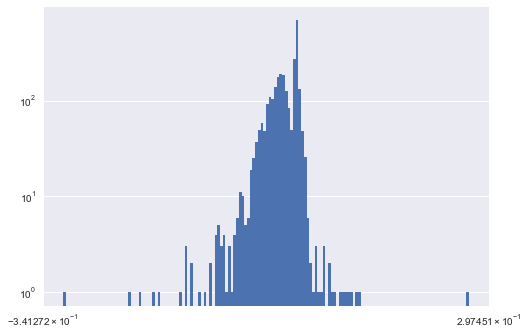

In [9]:
#Showing distribution of HPRs
plt.hist(trade_journal, bins=150)
plt.xscale('symlog')
plt.yscale('log')
plt.show()